In [68]:
# Supress unnecessary warning messages

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [205]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from copy import deepcopy
from fancyimpute import MICE
from datetime import datetime
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

In [185]:
with open('./data/raw/user_subset.pkl', 'rb') as picklefile:
    user = pickle.load(picklefile)
with open('./data/raw/session_subset.pkl', 'rb') as picklefile:
    session = pickle.load(picklefile)

## Format and split user data

In [164]:
# Impute the missing action_type and action_details with mode values
def impute_mode(df, col_key, col_na, mode_table=None):
    
    if (mode_table == None):
        mode_series = df[~df[col_na].isna()].groupby(col_key)[col_na].agg(lambda x:x.value_counts().index[0])
        mode_series = pd.DataFrame(mode_series.reset_index())
    else:
        mode_series = mode_table
    merged_frame = pd.merge(df, mode_series, how='left', 
                             left_on=[col_key], 
                             right_on=[col_key]).set_index(df.index)
    
    merged_frame.rename(columns={col_na+'_x': col_na, col_na+'_y':'mode_value'}, inplace=True)
    merged_frame[col_na].fillna(merged_frame.mode_value, inplace=True)
    merged_frame.drop(['mode_value'], axis=1, inplace=True)
    
    return merged_frame, mode_table

In [165]:
def date_transformation(user):
    user['date_account_created'] = pd.to_datetime(user['date_account_created'], format='%Y-%m-%d')
    user['timestamp_first_active'] = pd.to_datetime(user['timestamp_first_active']//10000, format='%Y%m%d%H')
    user.drop('date_first_booking', axis=1, inplace=True)
    #user['account_age'] = user['date_account_created'].apply(lambda x:(x.year-1970)*12+x.month)
    user['create_year'] = user['date_account_created'].apply(lambda x:x.year)
    user['create_month'] = user['date_account_created'].apply(lambda x:x.month)
    
    #user['active_age'] = user['timestamp_first_active'].apply(lambda x:(x.year-1970)*12+x.month)
    user['active_year'] = user['timestamp_first_active'].apply(lambda x:x.year)
    user['active_month'] = user['timestamp_first_active'].apply(lambda x:x.month)
    user['active_hour'] = user['timestamp_first_active'].apply(lambda x:x.hour)
    y_user = pd.DataFrame(user['country_destination'].values, columns=['country_destination'], index=user.id)
    X_user = user.drop(['country_destination'], axis=1)
    X_user.set_index('id', inplace=True)
    return X_user, y_user

#### Probably not needed
with open('./data/processed/X_user_train.pkl', 'wb') as picklefile:
    pickle.dump(X_user_train, picklefile)
with open('./data/processed/X_user_test.pkl', 'wb') as picklefile:
    pickle.dump(X_user_test, picklefile)
with open('./data/processed/y_user_train.pkl', 'wb') as picklefile:
    pickle.dump(y_user_train, picklefile)
with open('./data/processed/y_user_test.pkl', 'wb') as picklefile:
    pickle.dump(y_user_test, picklefile)

## Deal with wrong and missing values in user data

In [166]:
def impute_age(X_user_train):
    X_user_train.first_affiliate_tracked.fillna('catchall', inplace=True)
    X_user_train.loc[((X_user_train['age'] <= 18) | (X_user_train['age'] >= 100)), 'age' ] = np.NAN
    cols_to_drop = ['date_account_created', 'timestamp_first_active']
    X_user_train.drop(cols_to_drop, axis=1, inplace=True)

    # Imput data with median value
    # median_age = X_user_train[~X_user_train['age'].isna()].age.median()
    # X_user_train.loc[X_user_train['age'].isna(), 'age'] = median_age
    
    X_user_train, _ = impute_mode(X_user_train, 'first_device_type', 'age')
    return X_user_train

In [167]:
def custom_dummify(df, threshold, train_cols=None):
    df_concat = pd.DataFrame()
    df_noncat = df.select_dtypes(exclude='object')
    # print(df_noncat.shape)
    df = df.select_dtypes(include='object')
    
    all_cols = []
        
    for column in range(len(df.columns)):
        col_name = df.columns[column]
        levels = df.iloc[:,column].value_counts()
        count_all = np.sum(levels)
        significant_cols = []
        for level_values in levels.index:
            if (levels[level_values]/count_all < threshold):
                pass
            else:
                significant_cols.append(level_values)
        df_dummy = pd.get_dummies(df[col_name], prefix=col_name)

        cols_to_keep = [(col_name+"_"+x) for x in significant_cols]
        if (train_cols != None):
            for x in cols_to_keep:
                if x not in train_cols:
                    cols_to_keep.remove(x)
        all_cols.extend(cols_to_keep)
        df_dummy_kept = pd.DataFrame(df_dummy[cols_to_keep], columns=cols_to_keep)
        df_dummy_agg = df_dummy.drop((cols_to_keep), axis=1)
        df_dummy_agg = pd.DataFrame(df_dummy_agg.sum(axis=1), columns=[col_name+'_catch_all'])
        df_unify = pd.concat([df_dummy_kept, df_dummy_agg], axis=1)
        df_concat = pd.concat([df_concat, df_unify], axis=1)
    # print(df_concat.shape)
    return pd.concat([df_noncat, df_concat], axis=1 ), all_cols

In [168]:
X_user, y_user = date_transformation(user)
X_user_train, X_user_test, y_user_train, y_user_test = train_test_split(X_user, y_user, test_size = 0.25, random_state=1234, stratify=y_user)
X_user_train = impute_age(X_user_train)
X_user_train, user_train_cols = custom_dummify(X_user_train, 0.01)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

## Split and deal with wrong and missing values in session data

In [186]:
def match_session_with_user(session):
    session.set_index('user_id', drop=False, inplace=True)
    train_index = list(X_user_train.index)
    session_train = session[session.user_id.isin(train_index)]
    session_test = session[~session.user_id.isin(train_index)]
    return session_train, session_test

with open('./data/processed/session_train.pkl', 'wb') as picklefile:
    pickle.dump(session_train, picklefile)
with open('./data/processed/session_test.pkl', 'wb') as picklefile:
    pickle.dump(session_test, picklefile)

In [187]:
def impute_session(session_train):
    # Replace NaN in action column with others
    session_train['action'].fillna("catch-all", inplace=True)
    # Clip the sessions longer than 24 hours to 24 hours
    session_train.loc[session_train['secs_elapsed']>24*3600, 'secs_elapsed'] = 24*3600
    return session_train

In [188]:
def get_session_cat_stats(user_df, session_df):
    session_stats = pd.DataFrame(index=user_df.index)
    cat_cols = list(session_df.select_dtypes(include='object').columns)[1:]
    
    for col in cat_cols:
        val_freq = Counter(session_df[col])
        sig_val = list(val_freq.keys())

        for val in sig_val:
            val_count = session_df.groupby(session_df.index).apply(lambda x, val=val, col=col: np.sum(x[col] == val))
            tmp = pd.DataFrame(val_count.values, columns=[col+'['+val+']'], index=val_count.index)
            session_stats = pd.merge(session_stats, tmp, how='left', left_index=True, right_index=True )
    return session_stats

In [189]:
session_train, session_test = match_session_with_user(session)
session_train = impute_session(session_train)
session_test = impute_session(session_test)
session_train, action_type_mode = impute_mode(session_train, 'action', 'action_type')
session_train, action_detail_mode = impute_mode(session_train, 'action', 'action_detail')
session_train, action_detail_mode = impute_mode(session_train, 'action', 'secs_elapsed')
session_train.fillna("catch-all", inplace=True)
session_stats = get_session_cat_stats(X_user_train, session_train)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [192]:
with open('./data/processed/session_stats.pkl', 'wb') as picklefile:
    pickle.dump(session_stats, picklefile)

## Combine session and user data

In [193]:
def quantile_range(x):
    return x.quantile(0.75)-x.quantile(0.25)

In [194]:
def get_session_continous_stats(user_df, session_df):
    session_sec_stats = session_df.groupby('user_id')['secs_elapsed'].agg([np.median, np.mean, np.std, skew, kurtosis, quantile_range])
    session_sec_stats.rename(columns={'median':'sess[median]', 'mean':'sess[mean]', 'std':'sess[std]', 'skew':'sess[skew]', 'kurtosis':'sess[kurtosis]', 'quan_range':'sess[quan_range]'}, inplace=True)
    user_df = user_df.merge(session_sec_stats, how='left', left_index=True, right_index=True)
    return user_df

In [195]:
X_user_train_1 = deepcopy(X_user_train)
X_user_train_1 = X_user_train_1.merge(session_stats, how='left', left_index=True, right_index=True)
X_user_train_1 = get_session_continous_stats(X_user_train_1, session_train)
X_user_train_1.fillna(0.0, inplace=True)

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: 'user_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


## Build a baseline model for NDF and Booking

In [199]:
y_bin = deepcopy(y_user_train)
y_bin['booking'] = 1 - (y_bin['country_destination'] == 'NDF').astype('int')
y_bin.drop(['country_destination'], axis=1, inplace=True)
y_train=y_bin

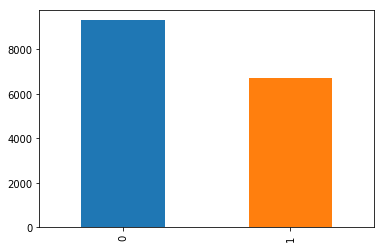

In [201]:
y_train['booking'].value_counts().plot('bar')

In [202]:
ssX = StandardScaler()
X_train_imputed_scaled = ssX.fit_transform(X_user_train_1)

In [ ]:
models = [('knn', KNN), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('xgboost', XGBClassifier),
          ('svc', SVC )
         ]

param_choices = [
    {
        'n_neighbors': range(3, 9, 2)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [1,3,5]
    },
    {
        'criterion':['gini','entropy'],
        'n_estimators': [10, 20, 50, 100],
        'min_samples_leaf':[1,3,5],
        'min_samples_split':[2,5,7]
    },
    {
        'max_depth': [3,5,7,9],
        'learning_rate': np.logspace(-3,0,5),
        'n_estimators': [10,50,80,100],
        'objective':['binary:logistic']
    },
    {
        'kernal': ['poly', 'rbf'],
        'degree': np.linspace(2, 8, 7), 
        'C': np.linspace(0.1, 10, 5)
    }
]


grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train_imputed_scaled, y_train)
    s = "{}: best score: {}".format(name, grid.best_score_)
    print(s)
    grids[name] = grid

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/si

knn: best score: 0.659525884390658


/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-v

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-v

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-v

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-v

**Result-Accuracy**<br>
knn: best score: 0.6414292853573214 <br>
logistic: best score: 0.6689780109945027 <br>
tree: best score: 0.698088455772114 <br>
forest: best score: 0.6454897551224388 <br>

**Result-AUC**<br>
knn: best score: 0.6797561404771426<br>
logistic: best score: 0.7137787331059189<br>
tree: best score: 0.7405620278725061<br>
forest: best score: 0.731510519720228<br>


knn: best score: 0.659525884390658

Best model - tree <br>
    
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5, <br>
            max_features=None, max_leaf_nodes=None,<br>
            min_impurity_decrease=0.0, min_impurity_split=None,<br>
            min_samples_leaf=10, min_samples_split=2,<br>
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,<br>
            splitter='best')

## Try XGBOOST

best parameters for xgboost:<br>
{'learning_rate': 0.1778279410038923,
 'max_depth': 5,
 'n_estimators': 80,
 'objective': 'binary:logistic'}

In [471]:
y_train_pred = grids['tree'].predict(X_train_imputed_scaled)

In [472]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

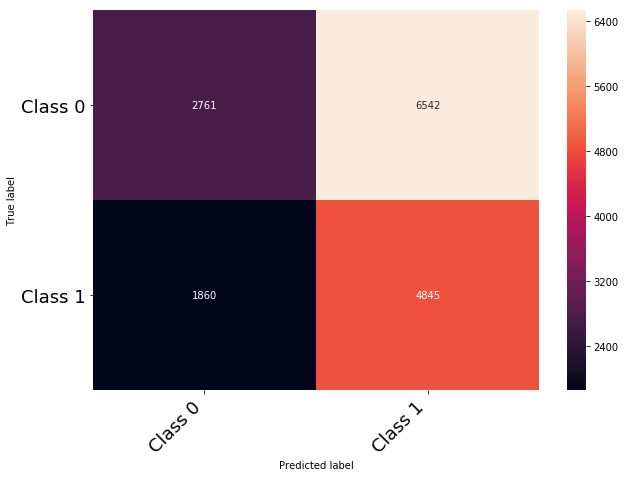

In [473]:
conf_mat = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
cm = print_confusion_matrix(conf_mat, ['Class 0', 'Class 1'])

In [496]:
grids['tree'].score(X_train_imputed_scaled, y_train)

0.4498637430068946

In [487]:
grids['tree'].best_score_

0.7405620278725061

In [ ]:
## Incporate prediction and seggregate y into sub-categories